In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
% matplotlib inline

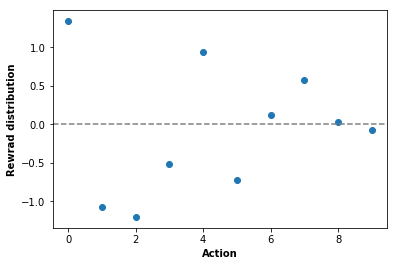

In [2]:
means = np.random.normal(0., 1., size=(10,))

plt.scatter(np.arange(10), means)
plt.axhline(y=0., color='gray', linestyle='--')
plt.xlabel("Action", fontweight='bold')
plt.ylabel("Rewrad distribution", fontweight='bold')
plt.show()

In [3]:
class BanditMachine(object):
    
    def __init__(self):
        self.means = np.random.normal(0., 1., size=(10,))
    
    def press_arm(self, arm_id):
        return np.random.normal(self.means[arm_id], 1.)

In [4]:
def e_greedy_algorithm(e, bandit, max_steps):
    
    reward_log = []
    action_log = []
    optimal_action = np.argmax(bandit.means)
    
    # Initializes Q_t(a) and N(a)
    action_values = np.zeros(shape=(10,), dtype=np.float) # estimates of the real action values, which are the bandit.means
    action_freq = np.zeros(shape=(10,), dtype=np.int)

    for t in range(max_steps):

        greed = np.random.uniform()
        if greed < e:
            a_t = np.random.randint(low=0, high=10)
        else:
            a_t = np.argmax(action_values)
        
        # Plays the bandit machine and get the reward
        R_t = bandit.press_arm(a_t)

        # Updates the action value
        action_freq[a_t] += 1
        action_values[a_t] = action_values[a_t] + 1/action_freq[a_t]*(R_t - action_values[a_t])
        
        reward_log.append(R_t)
        action_log.append(a_t)
    
    optimal_action_log = (np.array(action_log) == optimal_action)
    return reward_log, optimal_action_log

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:53<00:00, 17.70it/s]


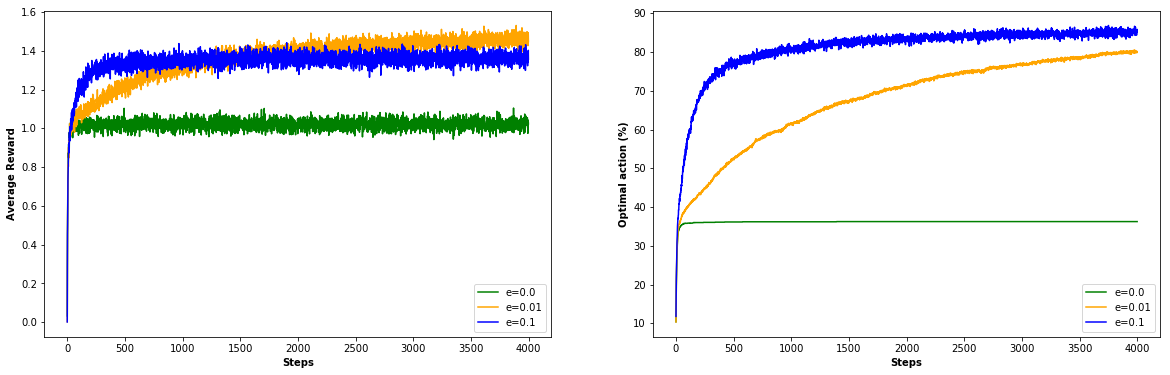

In [9]:
epsilons = [0.0, 0.01, 0.1]
max_steps = 4000
n_machines = 2000

plt.figure(figsize=(20, 6))

for col, e in zip(['green', 'orange', 'blue'], epsilons):
    master_reward_log = np.zeros(shape=(n_machines, max_steps), dtype=np.float)
    master_action_log = np.zeros(shape=(n_machines, max_steps), dtype=np.bool)

    for i in tqdm(range(n_machines)):
        bandit = BanditMachine()
        reward_log, optimal_action_log = e_greedy_algorithm(e, bandit, max_steps)

        master_reward_log[i, :] = reward_log
        master_action_log[i, :] = optimal_action_log

    avg_reward_log = np.mean(master_reward_log, axis=0)
    avg_action_log = np.mean(master_action_log, axis=0) * 100.
    
    plt.subplot(1,2,1)
    plt.plot(range(max_steps), avg_reward_log, color=col, label="e={}".format(e))
    plt.xlabel("Steps", fontweight='bold')
    plt.ylabel("Average Reward", fontweight='bold')
    plt.legend(loc='best')
    
    plt.subplot(1,2,2)
    plt.plot(range(max_steps), avg_action_log, color=col, label="e={}".format(e))
    plt.xlabel("Steps", fontweight='bold')
    plt.ylabel("Optimal action (%)", fontweight='bold')
    plt.legend(loc='best')
    
plt.show()